In [1]:
from geplearn.regressor import GEPRegressor
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from geplearn.encoders import TargetEncoder
from operator import add, mul, sub
import numpy as np
from sklearn.model_selection import train_test_split

Reading the data and splitting into training and testing.

In [2]:
data = pd.read_csv("./datasets/titanic.csv")
data.drop(["PassengerId", "Name", "Parch", "Ticket", "Cabin"], axis=1, inplace=True)
X = data.dropna().copy().drop("Survived", axis=1)
y = data.dropna().copy().loc[:, "Survived"]
train_index = int(0.7*len(X))
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), train_size=0.7, shuffle=True)

Preprocessing features. Categorical features are encoded using `TargetEncoder`.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
categorical_cols = ["Pclass", "Sex", "Embarked"]
pipe = Pipeline(steps=[("target_encoder", TargetEncoder(cols_to_transform=categorical_cols)), ("standard_scaler", StandardScaler())])
X_train_preprocessed = pipe.fit_transform(X_train, y_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
X_train_preprocessed.head()

,Pclass,Sex,Age,SibSp,Fare,Embarked
0,0.519055,1.262438,1.711587,-0.551169,-0.375235,-0.434040
1,1.337275,1.262438,0.225179,0.529470,1.104956,-0.955666
2,-0.964728,1.262438,-0.450461,-0.551169,-0.544257,-0.434040
3,-0.964728,-0.792118,-0.518025,0.529470,-0.550258,-0.434040
4,1.337275,1.262438,0.630563,0.529470,1.522676,2.146712


In [6]:
pipe["target_encoder"].mapping

{'Pclass': {1: 0.6590909090909091,
  2: 0.5126050420168067,
  3: 0.24696356275303644},
 'Sex': {'female': 0.7604166666666666, 'male': 0.20588235294117646},
 'Embarked': {'C': 0.6136363636363636,
  'Q': 0.3333333335113044,
  'S': 0.38046272493573263}}

Training a simple MLP model.

In [4]:
classifier = MLPClassifier(max_iter=1000)
classifier.fit(X_train_preprocessed.values, y_train.values)
print(accuracy_score(y_train.values, classifier.predict(X_train_preprocessed)), f1_score(y_train.values, classifier.predict(X_train_preprocessed)))

0.8755020080321285 0.845771144278607


Running the GEP algorithm to find a global surrogate model (mathematical expression).

In [15]:
gep_regressor = GEPRegressor(
    n_features=X_train_preprocessed.shape[1], 
    linker_function="sum_linker",
    functions_set=((add, 2), (sub, 2), (mul, 2)),
    fitness_func="correlation",
    direction="maximize",
    parallel_ind_evaluation=24,
    n_generations=200,
    warm_up=True,
    n_genes=10,
    pop_size = 100,
    tournsize=5,
    n_elites=10,
    n_runs=2,
)

In [16]:
gep_regressor.fit(X_train_preprocessed.values, classifier.predict_proba(X_train_preprocessed)[:, 1])

  0%|          | 0/2 [00:00<?, ?it/s]

gen	nevals	avg    	std      	min     	max     
0  	0     	0.65395	0.0578958	0.570653	0.799069
1  	90    	0.518373	0.210707 	0.00281019	0.826754
2  	90    	0.576957	0.220754 	0.003983  	0.826929
3  	90    	0.633322	0.185776 	0.0380953 	0.831448
4  	90    	0.62495 	0.203509 	0.00572234	0.849342
5  	90    	0.664351	0.1773   	0.0119349 	0.849342
6  	90    	0.679205	0.173425 	0.0539519 	0.849342
7  	90    	0.663306	0.169142 	0.000470125	0.849342
8  	90    	0.675516	0.173922 	0.0365711  	0.849342
9  	90    	0.687369	0.151804 	0.0351103  	0.849342
10 	90    	0.674538	0.219974 	0.000638314	0.849342
11 	90    	0.732997	0.124577 	0.218258   	0.849342
12 	90    	0.706786	0.15493  	0.0203873  	0.849342
13 	90    	0.729601	0.1332   	0.103427   	0.849342
14 	90    	0.710184	0.182613 	0.0688384  	0.849342
15 	90    	0.723789	0.139477 	0.0682044  	0.849342
16 	90    	0.714717	0.151679 	0.0717547  	0.858851
17 	90    	0.740196	0.12424  	0.0494258  	0.858851
18 	90    	0.723495	0.149974 	0.0299977  	0.8

 50%|█████     | 1/2 [05:46<05:46, 346.63s/it]

200	90    	0.703362	0.165109 	0.122091   	0.883572
gen	nevals	avg     	std      	min     	max     
0  	0     	0.665048	0.0511362	0.590074	0.815849
1  	90    	0.540844	0.191598 	0.0506753	0.815849
2  	90    	0.542356	0.225474 	0.0193547	0.842544
3  	90    	0.577677	0.211816 	0.0279693	0.842544
4  	90    	0.571625	0.215451 	0.00307755	0.842544
5  	90    	0.601288	0.199815 	0.0028213 	0.842544
6  	90    	0.55131 	0.235897 	0.0104154 	0.842544
7  	90    	0.597096	0.227936 	0.00314722	0.842544
8  	90    	0.589202	0.225439 	0.0408656 	0.842544
9  	90    	0.612252	0.225683 	0.00891583	0.842544
10 	90    	0.611907	0.230308 	0.0178586 	0.842544
11 	90    	0.596047	0.23773  	0.0172724 	0.856547
12 	90    	0.622023	0.226494 	0.0367445 	0.856547
13 	90    	0.624189	0.239877 	0.0293792 	0.856547
14 	90    	0.651985	0.212829 	0.0494456 	0.856547
15 	90    	0.64929 	0.216385 	0.0445622 	0.859005
16 	90    	0.6874  	0.187261 	0.0136723 	0.865566
17 	90    	0.623615	0.217858 	0.0529476 	0.865566
18 	90

100%|██████████| 2/2 [13:16<00:00, 398.34s/it]

200	90    	0.745281	0.157602 	0.100447  	0.892234


0.0487525745093426*X_0*(X_0 - 1)*(X_0 - 2*X_1) + 0.0975051490186851*X_0 + 0.341268021565398*X_1 - 0.0975051490186851*X_2 - 0.0487525745093426*X_3 + 0.0487525745093426*X_5 + 0.441342994082038

In [17]:
print(classification_report(y_train, classifier.predict(X_train_preprocessed)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       290
           1       0.88      0.82      0.85       208

    accuracy                           0.88       498
   macro avg       0.88      0.87      0.87       498
weighted avg       0.88      0.88      0.87       498



In [18]:
print(classification_report(y_train, np.where(gep_regressor.predict(X_train_preprocessed)>0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       290
           1       0.85      0.68      0.76       208

    accuracy                           0.82       498
   macro avg       0.83      0.80      0.81       498
weighted avg       0.82      0.82      0.81       498



The model can be saved and loaded using the `dill` package (similar to `pickle`).

In [25]:
import dill

dill.dump(gep_regressor, open("gep_regressor.model", "wb"))

In [4]:
gep_regressor = dill.load(open("gep_regressor.model", "rb"))

Performing some example analysis

In [5]:
import geplearn.analysis as gep_analysis

gep_analysis.summarize_model(X_train_preprocessed, gep_regressor, categorical_cols)

-----Model Summary-----

Symbolic Function:


0.0487525745093426*X_0*(X_0 - 1)*(X_0 - 2*X_1) + 0.0975051490186851*X_0 + 0.341268021565398*X_1 - 0.0975051490186851*X_2 - 0.0487525745093426*X_3 + 0.0487525745093426*X_5 + 0.441342994082038


----------

Number of independent variables used by the gep model: 5 of 6

----------

Categorical features utilized by the gep model:

{'X_0': 'Pclass', 'X_5': 'Embarked', 'X_1': 'Sex'}

Continuous features utilized by the gep model:

{'X_3': 'SibSp', 'X_2': 'Age'}


In [20]:
normalized_sensitivities = gep_analysis.compute_normalized_sensitivities(X_train_preprocessed, gep_regressor)

100%|██████████| 5/5 [00:00<00:00, 121.94it/s]


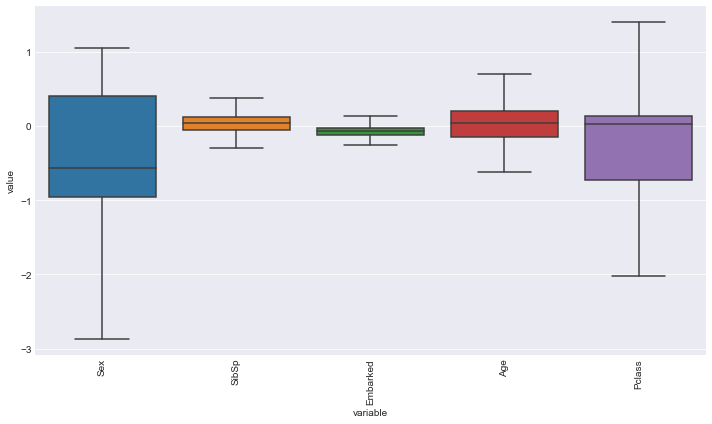

In [21]:
gep_analysis.boxplot_normalized_sensitivities(normalized_sensitivities)

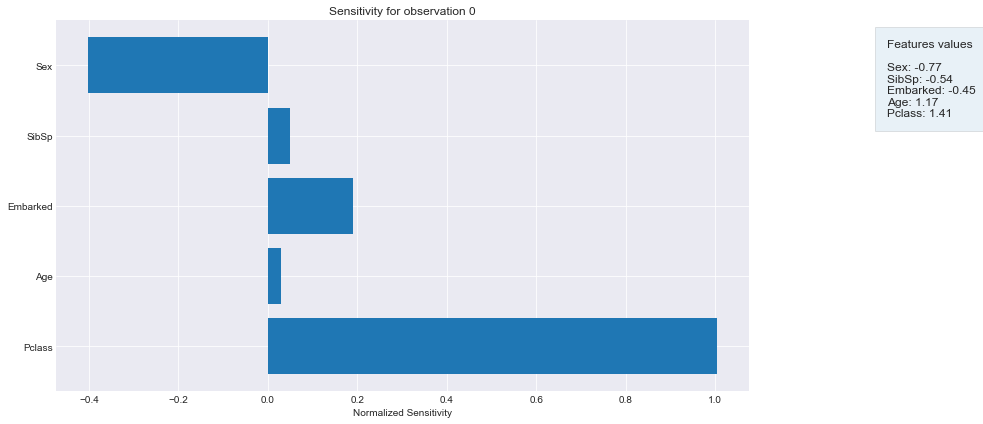

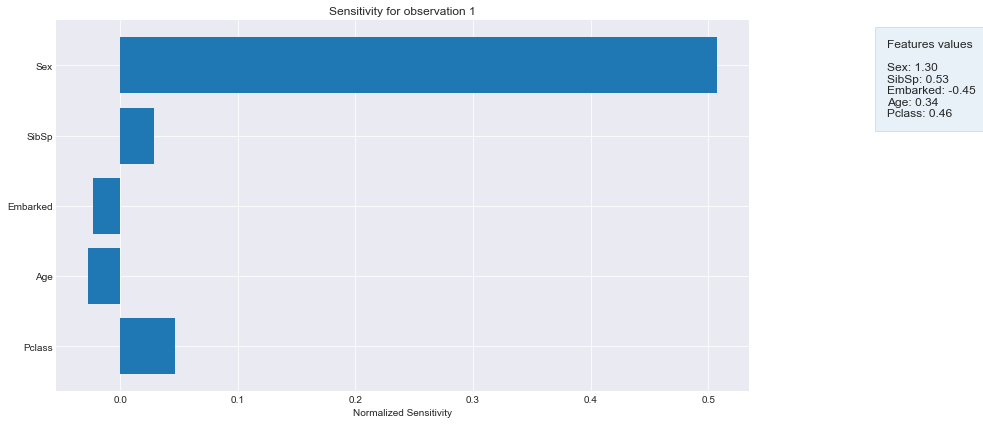

In [23]:
gep_analysis.plot_normalized_sensitivities_by_obs(X_train_preprocessed.sample(2), gep_regressor, normalized_sensitivities)

In [43]:
# The mapping in TargetEncoder contains the values before scaling.
col_name="Pclass"
col_index = X_train_preprocessed.columns.get_loc("Pclass")
mean = pipe["standard_scaler"].mean_[col_index]
std = pipe["standard_scaler"].scale_[col_index]
cat_mapping = {}
for k,v in pipe["target_encoder"].mapping[col_name].items():
    cat_mapping[k] = (v - mean)/std
cat_mapping

{1: 1.3372751894117978, 2: 0.5190548967216221, 3: -0.964728168875426}

0.0487525745093426*X_0*(X_0 - 1)*(X_0 + 1.58423606876268) + 0.0975051490186851*X_0 + 0.149857859643743

<ipython-input-49-1743d8cf5006>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


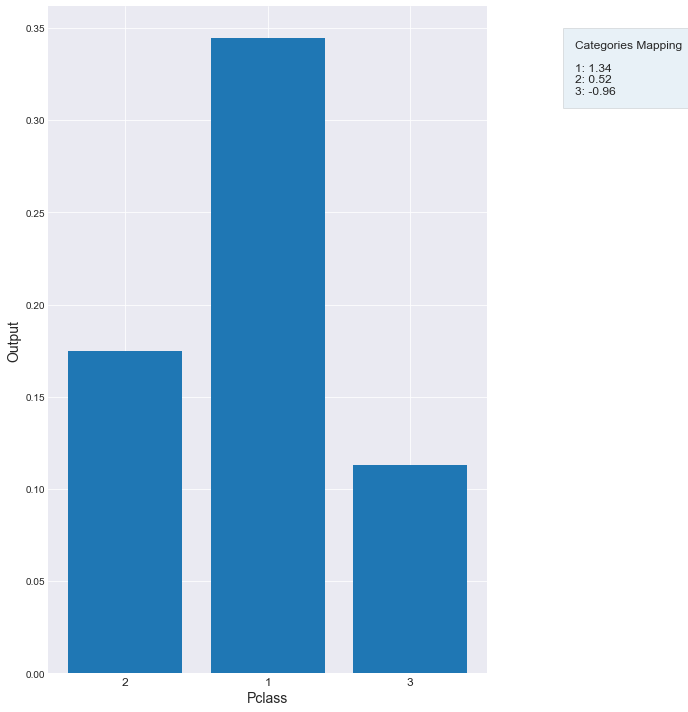

In [58]:
gep_analysis.averaged_effect(X_train_preprocessed, gep_regressor, "Pclass", categorical_cols, cat_mapping, 0)